In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [6]:
path = "data\\synthetic_water_potability_dataset.csv"

df = pandas.read_csv(path)
df.head()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.496714,141.075520,15017.850753,6.451407,177.551876,514.446714,9.626175,59.031321,7.973703,0
1,6.861736,83.095393,21103.591930,5.611756,185.409391,488.019167,13.950017,71.598409,2.109826,0
2,7.647689,209.671858,11770.652980,6.790766,387.980972,492.174322,3.276440,70.676286,3.319215,0
3,8.523030,284.276177,12363.022854,1.603717,213.726017,325.077319,8.001524,95.452368,9.496383,0
4,6.765847,309.831595,5806.648094,5.772676,102.875692,488.229248,2.320308,38.917186,8.414702,0


In [7]:
# find missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
pH                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


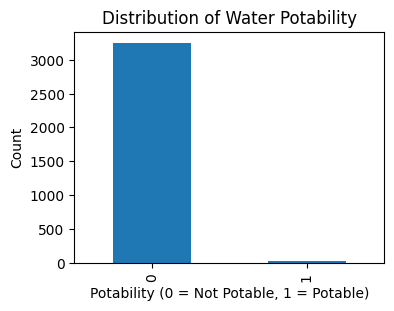

In [12]:
# plot distribution of potability
plt.figure(figsize=(4, 3))
df['Potability'].value_counts().plot(kind='bar')
plt.title('Distribution of Water Potability')
plt.xlabel('Potability (0 = Not Potable, 1 = Potable)')
plt.ylabel('Count')
plt.show()

In [10]:
# major class imbalance detected
# lets add more 1 potability samples using SMOTE
from imblearn.over_sampling import SMOTE

X = df.drop('Potability', axis=1)
y = df['Potability']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

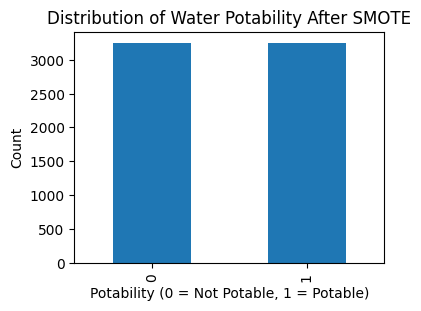

In [13]:
# plot classes distribution after resampling

plt.figure(figsize=(4, 3))
y_resampled.value_counts().plot(kind='bar')
plt.title('Distribution of Water Potability After SMOTE')
plt.xlabel('Potability (0 = Not Potable, 1 = Potable)')
plt.ylabel('Count')
plt.show()

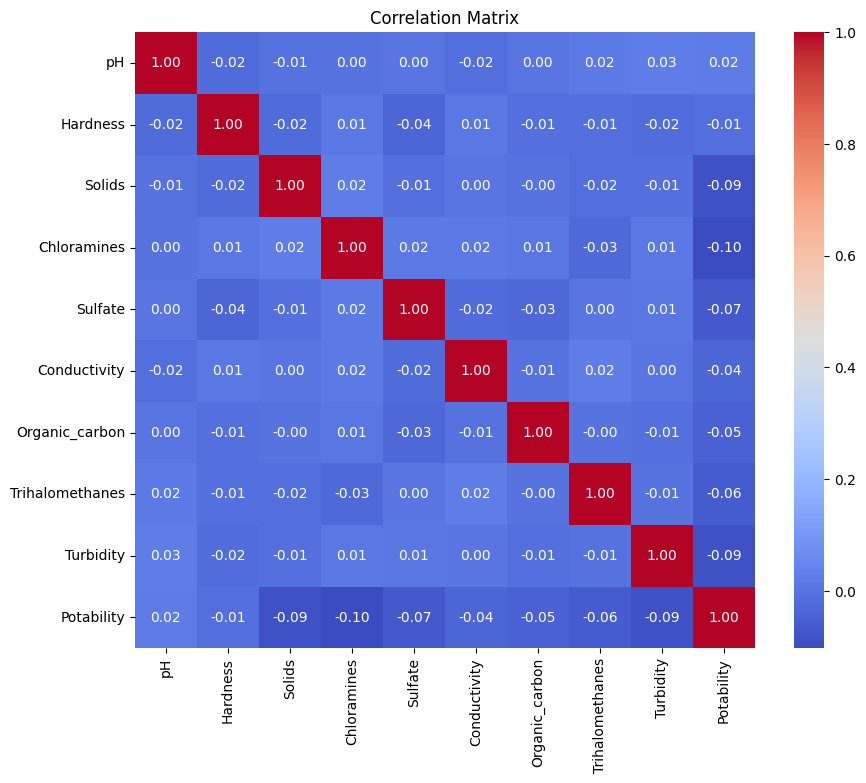

In [15]:
# plot correlation matrix

import seaborn as sns

plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [14]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 5198
Test set size: 1300


Confusion Matrix:
[[647   7]
 [  0 646]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       654
           1       0.99      1.00      0.99       646

    accuracy                           0.99      1300
   macro avg       0.99      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300



c:\Programming\Python projekty\data_analytics\data_analytics_learning_repo\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:47:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


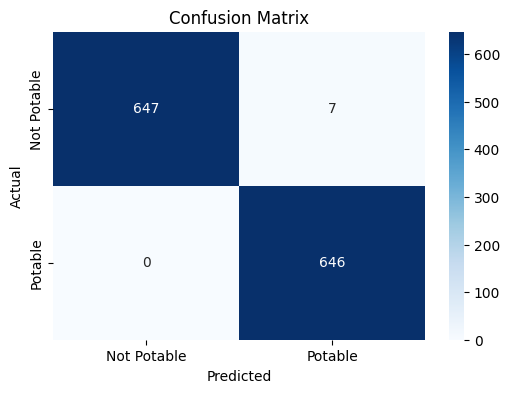

In [17]:
# train XGBoost model

from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# evaluate model
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# plot confusion matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Potable', 'Potable'], yticklabels=['Not Potable', 'Potable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [19]:
# hyperparameter tuning with GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                           param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}


c:\Programming\Python projekty\data_analytics\data_analytics_learning_repo\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:49:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix for Best Model:


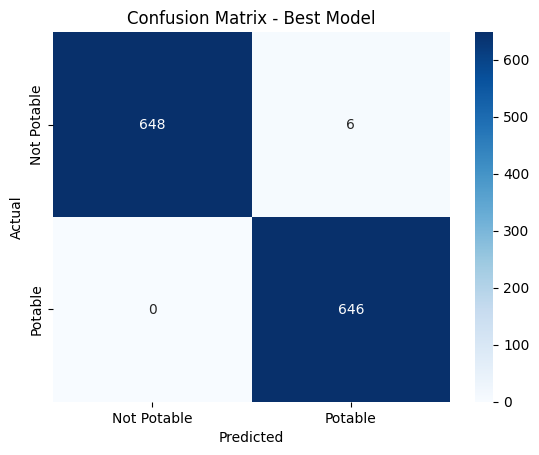

In [21]:
# use best estimator to predict

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Confusion Matrix for Best Model:")
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Potable', 'Potable'], yticklabels=['Not Potable', 'Potable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Best Model')
plt.show()